Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
--2025-06-25 10:51:11--  https://dl.google.com/linux/direct/google-chr

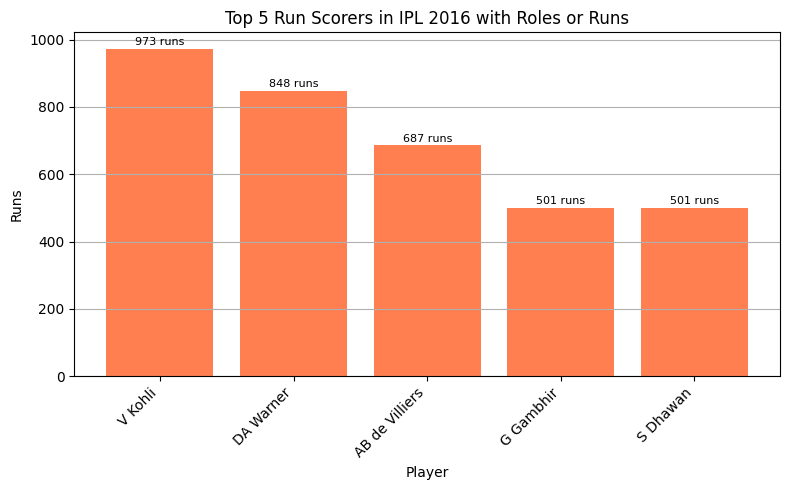

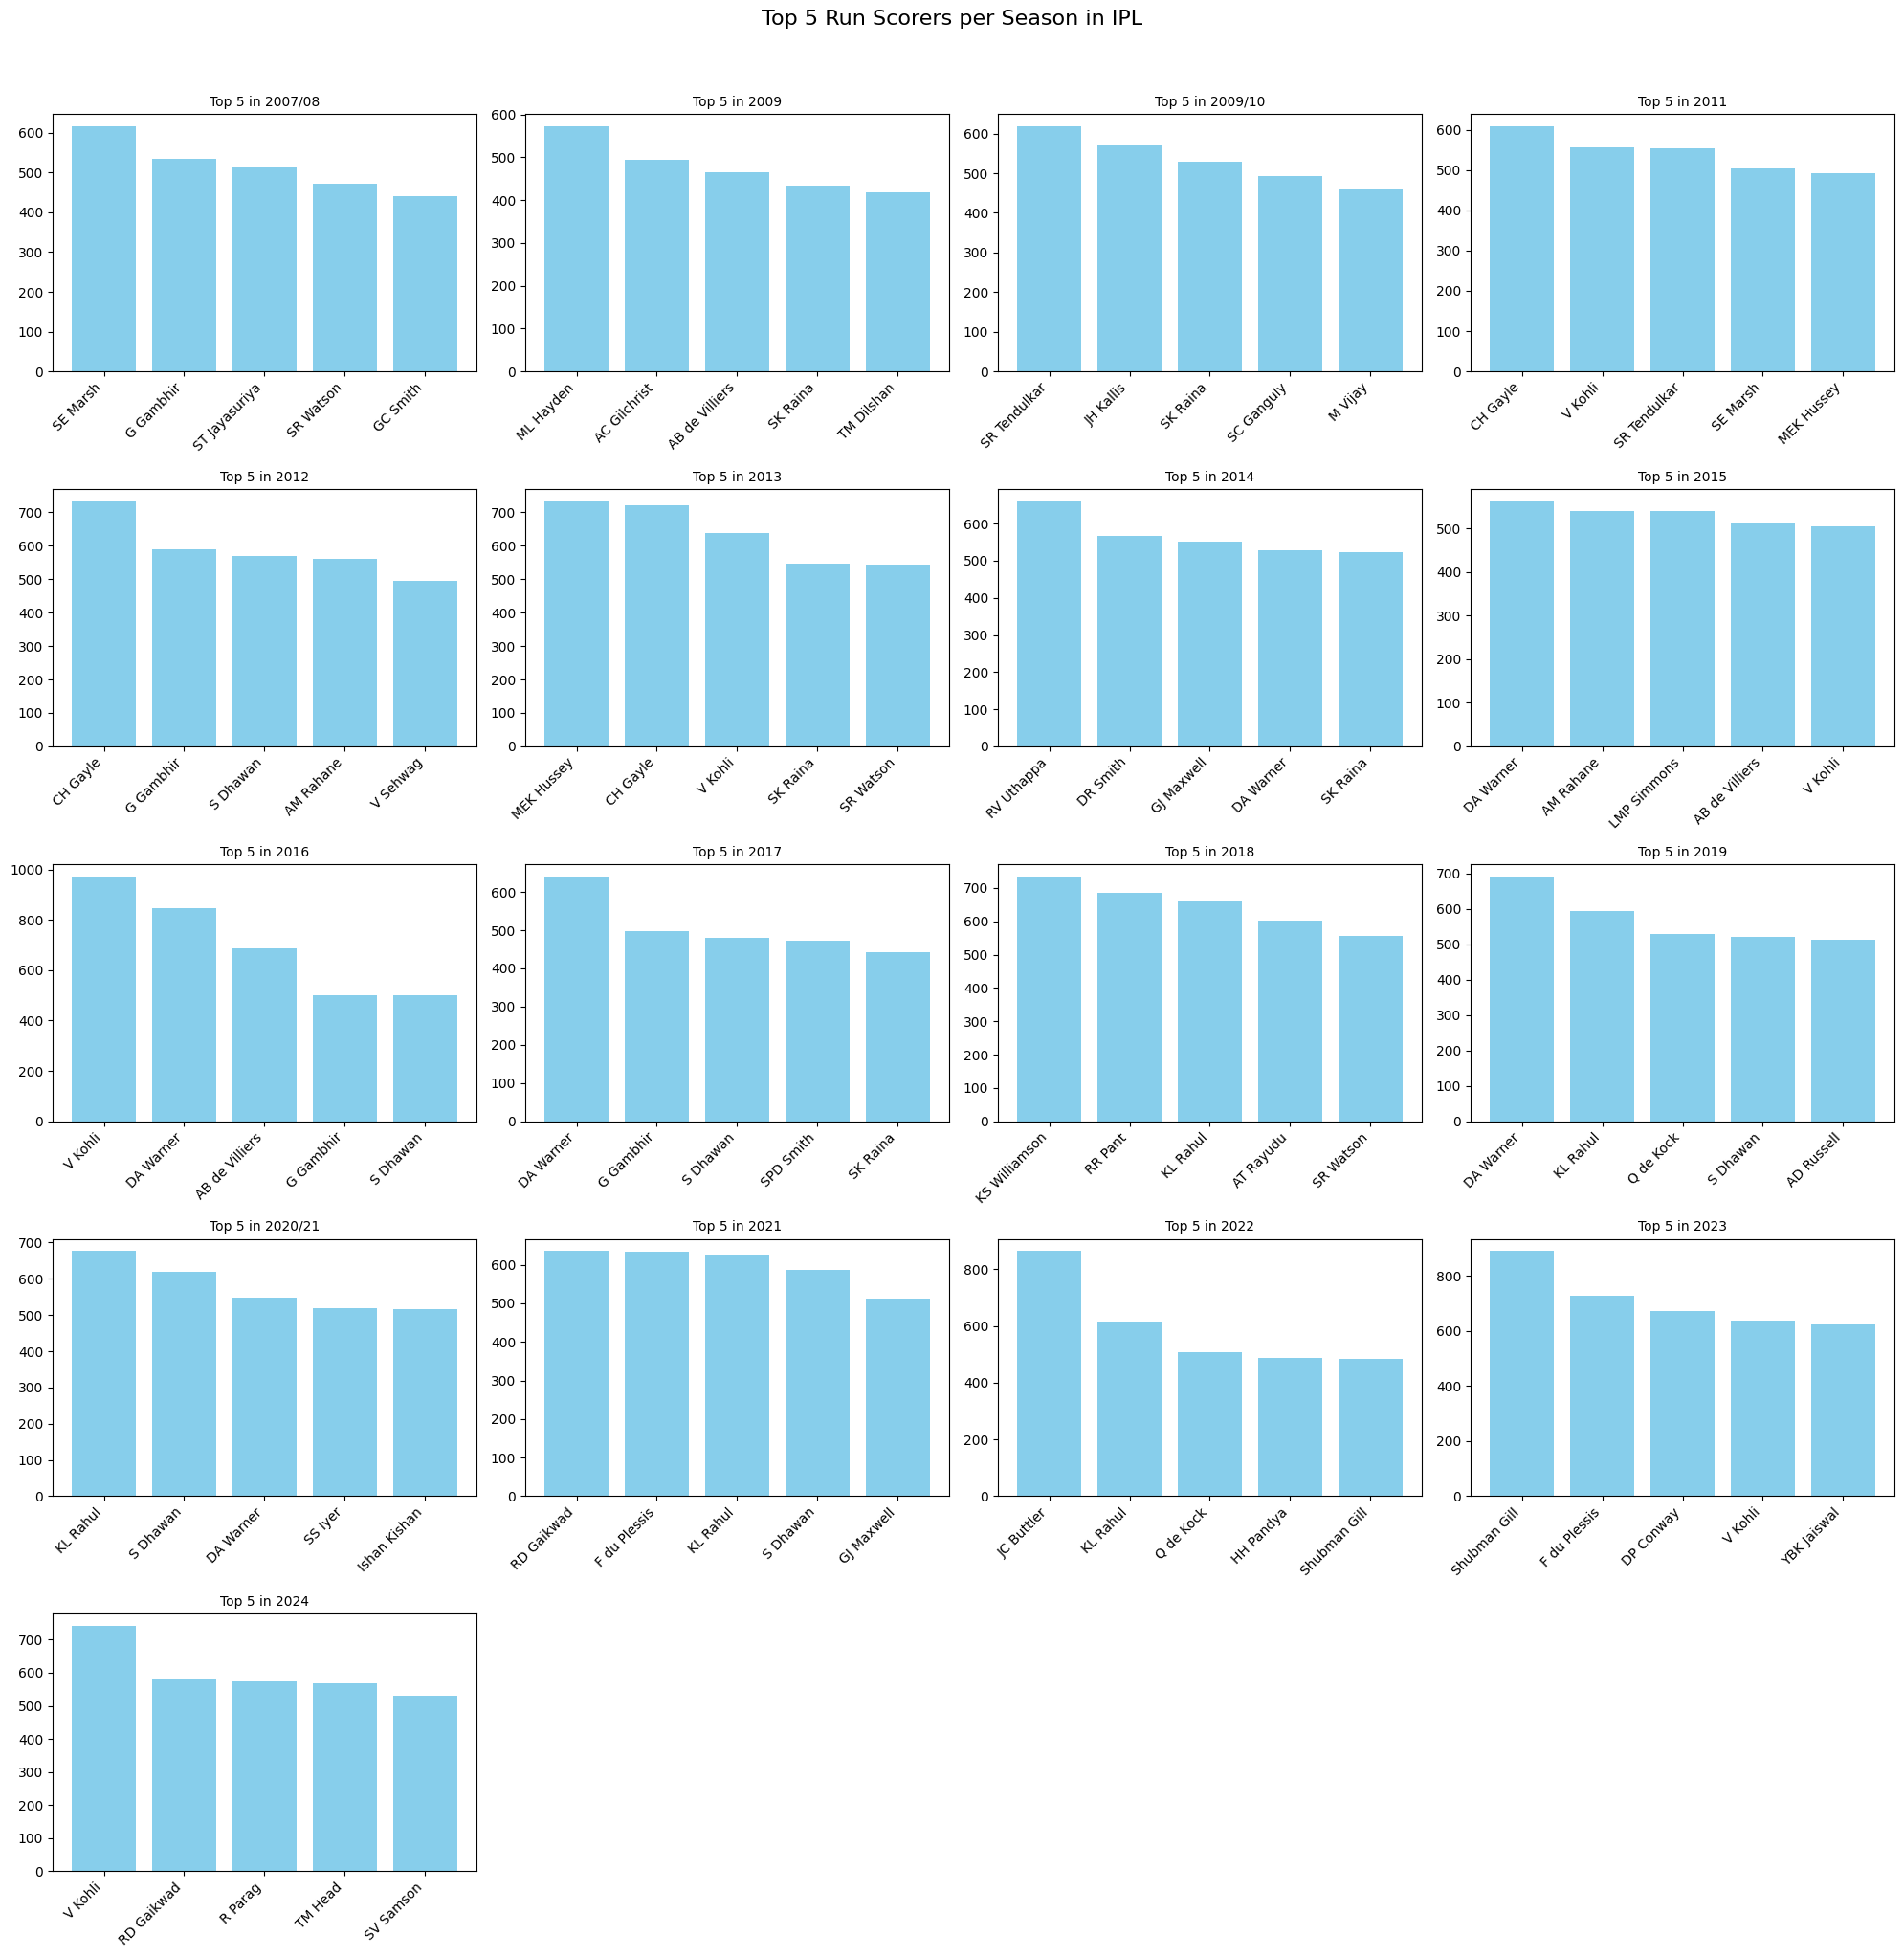

In [6]:
!apt-get update
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb || apt-get install -f -y
!apt-get install -y fonts-liberation

!pip install selenium webdriver-manager pandas matplotlib numpy plotly beautifulsoup4

import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time


matches = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')
matches['season'] = matches['season'].astype(str)
matches.info()
matches.describe()
deliveries.info()
deliveries.describe()
merged = deliveries.merge(matches[['id', 'season']], left_on='match_id', right_on='id')

season_runs = (
    merged.groupby(['season', 'batter'])['batsman_runs']
    .sum()
    .reset_index()
    .sort_values(['season', 'batsman_runs'], ascending=[True, False])
)

selected_season = '2016'
top5_2016 = season_runs[season_runs['season'] == selected_season].head(5)


options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)


url = "https://www.iplt20.com/teams/mumbai-indians/squad"
driver.get(url)
time.sleep(5)

soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

players = []
for card in soup.find_all("div", class_="player-card-description"):
    name = card.find("h3").text.strip()
    role = card.find("p").text.strip()
    players.append((name, role))

df_players = pd.DataFrame(players, columns=["Player", "Role"])


top5_2016 = top5_2016.merge(df_players, left_on='batter', right_on='Player', how='left')


plt.figure(figsize=(8,5))
plt.bar(top5_2016['batter'], top5_2016['batsman_runs'], color='coral')
plt.title(f"Top 5 Run Scorers in IPL {selected_season} with Roles or Runs")

for i, row in top5_2016.iterrows():
    label = row['Role'] if pd.notna(row['Role']) else f"{row['batsman_runs']} runs"
    plt.text(row['batter'], row['batsman_runs'] + 10, label, ha='center', fontsize=8)

plt.xlabel("Player")
plt.ylabel("Runs")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


fig = px.bar(
    top5_2016,
    x='batter',
    y='batsman_runs',
    color='batsman_runs',
    title=f"Top 5 Run Scorers in IPL {selected_season} (Interactive)",
    labels={'batter': 'Player', 'batsman_runs': 'Runs'}
)
fig.show()


unique_seasons = sorted(season_runs['season'].unique())


num_seasons = len(unique_seasons)
cols = 4
rows = (num_seasons + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 4))


for i, season in enumerate(unique_seasons):
    top5 = season_runs[season_runs['season'] == season].head(5)


    plt.subplot(rows, cols, i + 1)
    plt.bar(top5['batter'], top5['batsman_runs'], color='skyblue')
    plt.title(f"Top 5 in {season}", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()


plt.suptitle("Top 5 Run Scorers per Season in IPL", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

for season in unique_seasons:
    top5 = season_runs[season_runs['season'] == season].head(5)
    fig = px.bar(
        top5,
        x='batter',
        y='batsman_runs',
        title=f'Top 5 Run Scorers in IPL {season}',
        labels={'batsman_runs': 'Runs'},
        color='batsman_runs'
    )
    fig.show()